# Mnist with octopusal connector

In the [previous notebook](https://nbviewer.jupyter.org/github/marconunnari/octopusal_networks/blob/master/Mnist.ipynb) I used [octopusal networks](https://nbviewer.jupyter.org/github/marconunnari/octopusal_networks/blob/master/OctopusalNetworks.ipynb) to recognize the handwritten digits contained in the MNIST database. The problems was that it took more than 5 minutes to train the algorithm on just 500 training examples and the accuracy on 250 test examples was of 86%.

I then figured out that the only features of the octopusal networks necessary to recognize the digits was the soreness of the tentacles. So I abstracted the soreness in numpy arrays and the result is terribly faster. It now takes around 2 seconds to train on 60000 training examples and get 94.63% accuracy on 10000 test examples. All on CPU.

It is still dependent on the convolutional base and in retrospective it is a very easy approach to which probably someone has arrived before me. It could be useful for transfer learning if we get a general convolutional base or some similar system that extract features.

Beside that it on the side of performance and usefulness doesn't have any advantages on neural networks, the only relevant thing is that it is compatible with the brain.

In [1]:
from OctopusalConnector import OctopusalConnector

## Convolutional base

Here I use a convolutional base trained with a neural network to extract the main features from the images. So that the input of the vectorized octopusal networks will be a set of specific features rather than the actual pixels.

The main result of this extraction is an array of activations for each images. This array will contain `1` where the convolutional base outputs more than a certain threshold and `0` where the convolutional base outputs less than the threshold.

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np

from progress_bar import ProgressBar
from keras.models import Model
from keras.datasets import mnist
from keras.models import load_model

np.set_printoptions(suppress=True)

model = load_model('./cnn_minst.h5')
layer_name = 'flatten_1'
conv_base = Model(inputs=model.input,
                  outputs=model.get_layer(layer_name).output)

data = mnist.load_data()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def extract_activations(conv_base, images, threshold):
    images_mod = images.reshape((images.shape[0], 28, 28, 1)).astype('float32') / 255
    features = conv_base.predict(images_mod, verbose=1)
    features = features * 100
    features = features.astype(int)
    features = features > threshold
    features = features.astype(int)
    return features

    
def extract_features(features_extractor, data, threshold=60):
    (train_images, train_labels), (test_images, test_labels) = data
    print('Extracting train features')
    train_features = extract_activations(conv_base, train_images, threshold)
    print('Extracting test features')
    test_features = extract_activations(conv_base, test_images, threshold)
    print()
    return (train_features, test_features)

In [4]:
# extract train and test features
(train_images, train_labels), (test_images, test_labels) = data
(train_features, test_features) = extract_features(conv_base, data, threshold=60)

Extracting train features
60000/60000 [==============================] - 9s 142us/step
Extracting test features
10000/10000 [==============================] - 1s 141us/step



## Training

First we create an array of length 10 for each digit. This array consists of all `0` except a `1` in the position corresponding digit. To be clear for the digit 2 the array will be `[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]`

In [5]:
def create_digit(digit):
    result = np.zeros(10)
    result[digit] = 1
    return result

def create_digits():
    zero = create_digit(0)
    one = create_digit(1)
    two = create_digit(2)
    three = create_digit(3)
    four = create_digit(4)
    five = create_digit(5)
    six = create_digit(6)
    seven = create_digit(7)
    eight = create_digit(8)
    nine = create_digit(9)
    digits = [zero, one, two, three, four, five, six, seven, eight, nine]
    return digits

Now the actual training. First we inititialize a numpy array of shape `(576, 10)` that represent the soreness of the tentacles. `576` is the number of octopuses (or the number of features extracted from the convolutional base). `10` is the number of tentacles that go from each 'octopus feature' to each 'octopus digit' (or simply the number of digits).

Then for each digit in the training examples, we compute the outer product between the features extracted and the array correspond to the digit. With this we get an array with shape `(576, 10)` with ones only on the tentacles that go from the activated features to the digit. We call this array `soreness_increment` and we add this to the previous array of `soreness`, so that will increase the `soreness` of the tentacles that go from the activated features to the digit.

In [6]:
count = 60000

digits = create_digits()

connector = OctopusalConnector(576, 10)

print(f"Training examples: {count}")
pb = ProgressBar(count)
time_start = time.time()

for index in range(count):
    digit = digits[train_labels[index]]
    features = train_features[index]
    
    connector.train(features, digit)

    pb += 1

time_elapsed = time.time() - time_start
print(f" Time elapsed: {time_elapsed:.2f}s")
del pb

Training examples: 60000
  100% [=================================================================] Time elapsed: 1.86s



## Prediction

To make a prediction we convert the vector of activations extracted from the convolutional base to a column vector and then multiply it for the soreness. In this way we get an array of shape `(576, 10)` where there is only the `soreness` of the tentacles of the activated octopuses (corresponding to the activated features). Then we sum the values on the columns obtaining an array of length 10 where each element is the sum of the `soreness` of all tentacles pointing to the the digit. We then see which digits are the more connected to the activated features.

The argument `tolerance` indicates how many indexes we extract, if for example `tolerance = 2` we treat as predictions the two most connected digits. The default value is `1` to get only one firm prediction.

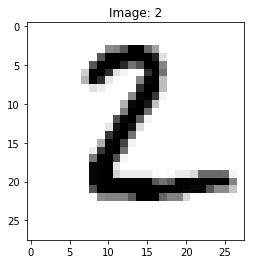

Prediction correct: True


In [7]:
def predict(index, tolerance=1):
    features = test_features[index]
    output = connector.predict(features)
    predictions = list(np.argpartition(output, -2)[-tolerance:])
    label = test_labels[index]
    return label in predictions

def show_image(image, label):
    plt.title(f'Image: {label}')
    plt.imshow(image, cmap=plt.cm.binary)
    plt.show()

index = 1
show_image(test_images[index], test_labels[index])
correct = predict(index, tolerance=2)
print(f'Prediction correct: {correct}')

## Accuracy

To compute the accuracy of the model we loop over each digit in the test dataset and we count how many predictions are correct. The argument `count` indicates how many test samples we consider.

In [8]:
def accuracy(count, tolerance=1):
    correct = 0
    print(f"Test samples: {count}\n")
    pb = ProgressBar(count)
    time_start = time.time()
    for i in range(count):
        result = predict(i, tolerance=tolerance)
        if result == True:
            correct += 1
        pb += 1
    time_elapsed = time.time() - time_start
    print(f" Time elapsed: {time_elapsed:.2f}s")
    del pb
    print(f"Correct: {correct / count * 100:.2f}%")

### Tolerance 1

With `tolerance = 1` we get 94.63% accuracy on 10000 test samples

In [9]:
accuracy(10000, 1)

Test samples: 10000

  100% [=================================================================] Time elapsed: 0.54s

Correct: 94.63%


### Tolerance 2

With `tolerance = 2` we get 98.32% accuracy on 10000 test samples

In [10]:
accuracy(10000, 2)

Test samples: 10000

  100% [=================================================================] Time elapsed: 0.56s

Correct: 98.32%


<p style="text-align: right"><i>Marco Nunnari<br>May 2018</i></p>